<a href="https://colab.research.google.com/github/Swathi1309/Data_Analytics/blob/main/Predicting%20Car%20Quality%20Using%20Random%20Forests/Random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest to Build a Predictive Model on the Car Evaluation Dataset

In [ ]:
## Importing libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import seaborn as sns

!pip install -U imbalanced-learn
import imblearn
from imblearn.over_sampling import SMOTEN

from collections import OrderedDict

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, plot_confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

## Supporting functions to plot various data distributions

In [2]:
# Plotting the distribution of all features
def plot_dist(data):
  colors = sns.color_palette('pastel')
  print ("Number of data points = ", data.shape[0])
  print ("Distribution of data points:")
  rows = int(np.ceil(data.shape[1]/4))
  fig, ax = plt.subplots(rows, 4, figsize = (12,rows*3))
  i = 0
  j = 0
  for column in data:
    counts = pd.DataFrame(data[column].value_counts())
    labels = counts.index.values.tolist()
    values = data[column].value_counts().tolist()
    ax[i][j].pie(values, labels = labels, colors = colors)
    ax[i][j].set_title(column)
    if j<3:
      j += 1
    else:
      i += 1
      j = 0
  while j<=3:
    ax[i][j].set_axis_off()
    j+=1

In [3]:
# Function to plot input variables pairwise
def plot_pairwise(data):
  cols = data.columns.tolist()
  num = len(cols) - 1
  fig, ax = plt.subplots(num, num, figsize = (4*num, 4*num))
  for i in range(num):
    for j in range(num):
      if j<i:
        ax[j][i].set_axis_off()
      else:
        if i==j:
          if i==num-1:
            sns.histplot(x=cols[i], hue="target", data=data, multiple="stack", palette={"unacc":"skyblue", "acc":"orange", "good":"palegreen", "vgood":"salmon"}, ax=ax[j][i]);
          else:
            sns.histplot(x=cols[i], hue="target", data=data, multiple="stack", palette={"unacc":"skyblue", "acc":"orange", "good":"palegreen", "vgood":"salmon"}, ax=ax[j][i], legend=False);
          if j!=num-1:
            ax[j][i].set_xlabel(" ")
          if i!=0:
            ax[j][i].set_ylabel(" ")
        else:  
          df = pd.DataFrame(data.groupby([cols[i], cols[j], "target"]).size().reset_index().rename(columns={0:'freq'}))
          sns.scatterplot(data=df, x=cols[i], y=cols[j], size="freq", hue="target", sizes=(20, 5000), palette={"unacc":"skyblue", "acc":"orange", "good":"palegreen", "vgood":"salmon"}, alpha=0.5, legend=False, ax=ax[j][i]);
          if j!=num-1:
            ax[j][i].set_xlabel(" ")
          if i!=0:
            ax[j][i].set_ylabel(" ")
  fig.savefig("pairwise", format="svg", pad_inches=0, bbox_inches ="tight")

In [4]:
def encode_data(data):
  data["buying"].replace(to_replace = ["low", "med", "high", "vhigh"], value = [0,1,2,3], inplace=True)
  data["maint"].replace(to_replace = ["low", "med", "high", "vhigh"], value = [0,1,2,3], inplace=True)
  data["doors"].replace(to_replace = ["2","3","4","5more"], value = [0,1,2,3], inplace=True)
  data["persons"].replace(to_replace = ["2","4","more"], value = [0,1,2], inplace=True)
  data["lug_boot"].replace(to_replace = ["small","med","big"], value = [0,1,2], inplace=True)
  data["safety"].replace(to_replace = ["low","med","high"], value = [0,1,2], inplace=True)
  data["target"].replace(to_replace = ["unacc", "acc", "good", "vgood"], value = [0,1,2,3], inplace=True)

## Reading data, cleaning and visualizing

Number of data points =  1208
Distribution of data points:


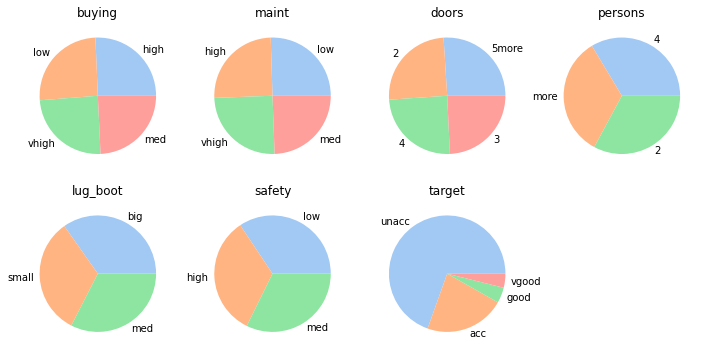

In [5]:
data = pd.read_csv("car_evaluation.csv")
data.columns=["buying", "maint","doors","persons","lug_boot","safety", "target"]

X = data[["buying", "maint","doors","persons","lug_boot","safety"]]
Y = data["target"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

data = pd.concat([X_train, Y_train], axis=1)
test_data = pd.concat([X_test, Y_test], axis=1)

# Plotting the distribution of unaugmented training data
plot_dist(data)

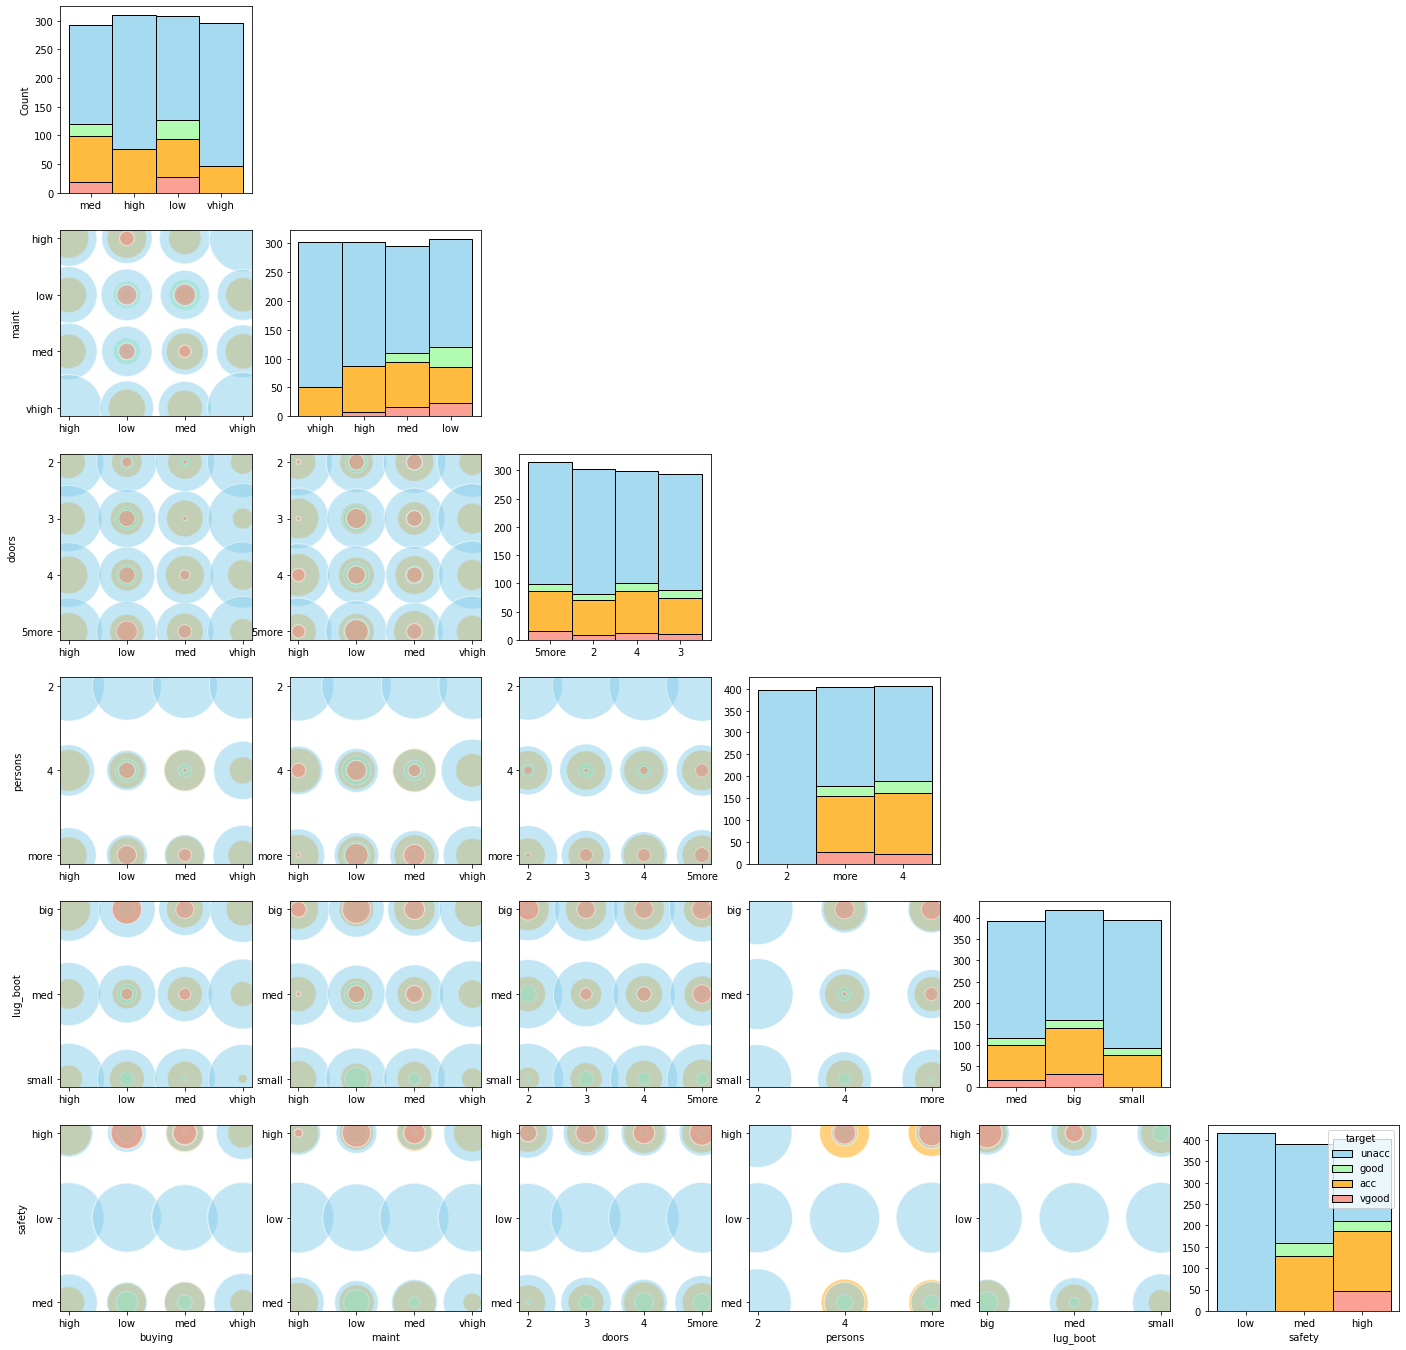

In [6]:
plot_pairwise(data)

In [7]:
encode_data(data)
encode_data(test_data)

## Building random forest model and tuning hyperparameters

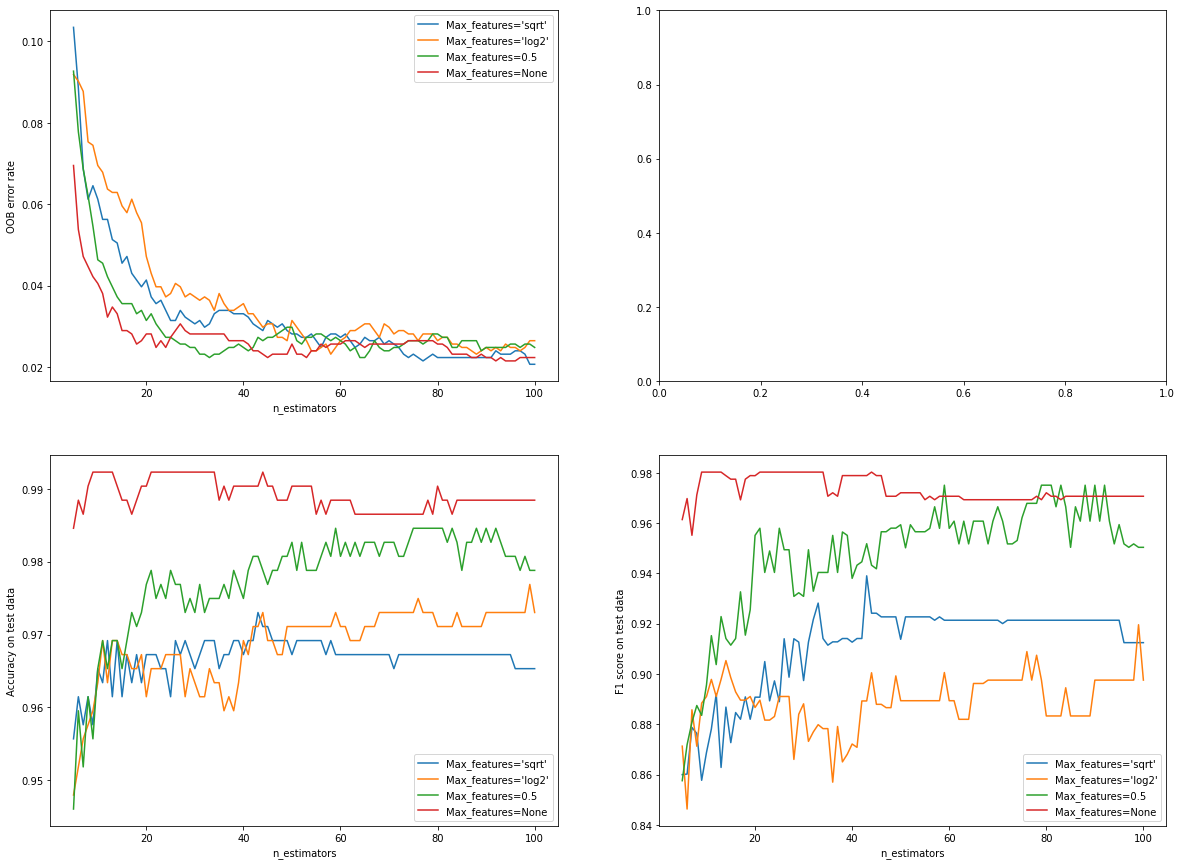

In [8]:
X = data[["buying", "maint","doors","persons","lug_boot","safety"]]
Y = data["target"]

X_test = test_data[["buying", "maint","doors","persons","lug_boot","safety"]]
Y_test = test_data["target"]

ensemble_clfs = [("Max_features='sqrt'",RandomForestClassifier(warm_start=True, oob_score=True, max_features="sqrt")),
                 ("Max_features='log2'",RandomForestClassifier(warm_start=True, max_features="log2", oob_score=True)),
                 ("Max_features=0.5", RandomForestClassifier(warm_start=True, max_features=0.5, oob_score=True)),
                 ("Max_features=None", RandomForestClassifier(warm_start=True, max_features=None, oob_score=True))]

error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)
accuracy = OrderedDict((label, []) for label, _ in ensemble_clfs)
f1 = OrderedDict((label, []) for label, _ in ensemble_clfs)

min_estimators = 5
max_estimators = 100

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, Y)
        score = clf.score(X_test, Y_test)
        Y_pred = clf.predict(X_test)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))
        accuracy[label].append((i, score))
        f1[label].append((i, f1_score(Y_pred, Y_test, average="macro")))

fig, ax = plt.subplots(2, 2, figsize = (20, 15))

for label, clf_err in error_rate.items():
    x1, y1 = zip(*clf_err)
    ax[0][0].plot(x1, y1, label=label);

ax[0][0].set_xlabel("n_estimators");
ax[0][0].set_ylabel("OOB error rate");
ax[0][0].legend(loc=0);

for label, clf_err in accuracy.items():
    x2, y2 = zip(*clf_err)
    ax[1][0].plot(x2, y2, label=label);

ax[1][0].set_xlabel("n_estimators");
ax[1][0].set_ylabel("Accuracy on test data");
ax[1][0].legend(loc=0);

for label, clf_err in f1.items():
    x3, y3 = zip(*clf_err)
    ax[1][1].plot(x3, y3, label=label);

ax[1][1].set_xlabel("n_estimators");
ax[1][1].set_ylabel("F1 score on test data");
ax[1][1].legend(loc=0);

## Performance of the best model

Training:
Accuracy =  1.0
Precision =  1.0
Recall =  1.0
F1 Score =  1.0
Test:
Accuracy =  0.9826589595375722
Precision =  0.9636698687958747
Recall =  0.9700258528068761
F1 Score =  0.9665331956888501
              precision    recall  f1-score   support

       unacc       1.00      0.99      0.99       369
         acc       0.94      0.98      0.96       115
        good       0.94      0.94      0.94        17
       vgood       1.00      0.94      0.97        18

    accuracy                           0.98       519
   macro avg       0.97      0.96      0.97       519
weighted avg       0.98      0.98      0.98       519



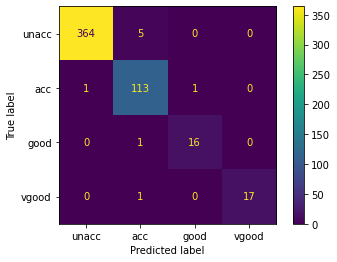

In [9]:
# Finding performance of the best model on training and test data
clf = RandomForestClassifier(warm_start=True, max_features=None, n_estimators=30)
clf.fit(X, Y)
y_train = clf.predict(X)
y_test = clf.predict(X_test)

print ("Training:")
print ("Accuracy = ", accuracy_score(y_train, Y))
print ("Precision = ", precision_score(y_train, Y, average="macro"))
print ("Recall = ", recall_score(y_train, Y, average="macro"))
print ("F1 Score = ", f1_score(y_train, Y, average="macro"))
print ("Test:")
print ("Accuracy = ", accuracy_score(y_test, Y_test))
print ("Precision = ", precision_score(y_test, Y_test, average="macro"))
print ("Recall = ", recall_score(y_test, Y_test, average="macro"))
print ("F1 Score = ", f1_score(y_test, Y_test, average="macro"))

print (classification_report(Y_test, y_test, target_names=["unacc", "acc", "good", "vgood"]))
plot_confusion_matrix(clf, X_test, Y_test, display_labels = ["unacc", "acc", "good", "vgood"]);

## Variable importance

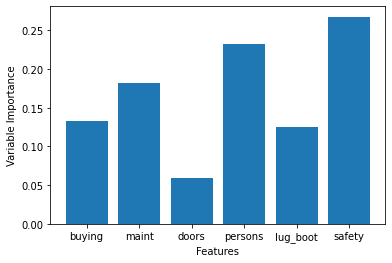

In [10]:
values = list(clf.feature_importances_)
labels = ["buying", "maint","doors","persons","lug_boot","safety"]

plt.bar(labels, values);
plt.xlabel("Features");
plt.ylabel("Variable Importance");